In [1]:
import numpy as np
import xarray as xr
from dask.diagnostics import ProgressBar
from xgcm import Grid
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

%matplotlib inline

In [2]:
#load pre-subsetted file (if available)
datapath = '/srv/scratch/z3526974/ROMS_at_mooring_sites/SYD/'
ts = xr.open_mfdataset(datapath + 'SYD_site_ROMS_subset_02.nc', 
                       chunks={'ocean_time': 1}, combine='by_coords', decode_coords=True)

In [3]:
ts

<xarray.Dataset>
Dimensions:      (Nuser: 25, boundary: 4, eta_psi: 7, eta_rho: 8, eta_u: 8, eta_v: 7, ocean_time: 1020, s_rho: 30, s_w: 31, tracer: 2, xi_psi: 9, xi_rho: 10, xi_u: 9, xi_v: 10)
Coordinates:
    lat_psi      (eta_psi, xi_psi) float64 dask.array<chunksize=(7, 9), meta=np.ndarray>
    lat_rho      (eta_rho, xi_rho) float64 dask.array<chunksize=(8, 10), meta=np.ndarray>
    lon_u        (eta_u, xi_u) float64 dask.array<chunksize=(8, 9), meta=np.ndarray>
    lon_v        (eta_v, xi_v) float64 dask.array<chunksize=(7, 10), meta=np.ndarray>
    lon_rho      (eta_rho, xi_rho) float64 dask.array<chunksize=(8, 10), meta=np.ndarray>
    lon_psi      (eta_psi, xi_psi) float64 dask.array<chunksize=(7, 9), meta=np.ndarray>
    lat_u        (eta_u, xi_u) float64 dask.array<chunksize=(8, 9), meta=np.ndarray>
    lat_v        (eta_v, xi_v) float64 dask.array<chunksize=(7, 10), meta=np.ndarray>
  * s_rho        (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w          (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
  * ocean_time   (ocean_time) datetime64[ns] 1995-06-25T12:00:00 ... 1998-04-09T12:00:00
Dimensions without coordinates: Nuser, boundary, eta_psi, eta_rho, eta_u, eta_v, tracer, xi_psi, xi_rho, xi_u, xi_v
Data variables:
    ntimes       (ocean_time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    ndtfast      (ocean_time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    dt           (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dtfast       (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dstart       (ocean_time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    nHIS         (ocean_time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    ndefHIS      (ocean_time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    nRST         (ocean_time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    ntsAVG       (ocean_time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    nAVG         (ocean_time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    ndefAVG      (ocean_time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    Falpha       (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Fbeta        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Fgamma       (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    nl_tnu2      (ocean_time, tracer) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    nl_visc2     (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akt_bak      (ocean_time, tracer) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    Akv_bak      (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akk_bak      (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akp_bak      (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rdrg         (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rdrg2        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Zob          (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Zos          (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Znudg        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    M2nudg       (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    M3nudg       (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Tnudg        (ocean_time, tracer) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    FSobc_in     (ocean_time, boundary) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>
    FSobc_out    (ocean_time, boundary) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>
    M2obc_in     (ocean_time, boundary) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>
    M2obc_out    (ocean_time, boundary) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>
    Tobc_in      (ocean_t

# Creating a grid object
While xgcm doesn't currently have an implementation for the SGRID convention for ROMS, a workaround consist on renaming eta_u and xi_v dimensions to rho to bring it in line with COMODO conventions. With this replacement 'psi' points have now a position (eta_v, xi_u). See issue here https://github.com/xgcm/xgcm/issues/108

Here I also test to see if the new XGCM 'metrics' functionality works.More info on xgcm: 
https://xgcm.readthedocs.io/en/latest/grids.html
and how metrics work:
https://xgcm.readthedocs.io/en/latest/grid_metrics.html

In [4]:
# Including metrics
ds = ts.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}}

grid = Grid(ds, coords=coords, periodic=[])

# decode vertical coordinate
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')

# get distances between points on all grids
ds['pm_v'] = grid.interp(ds.pm, 'Y')
ds['pn_u'] = grid.interp(ds.pn, 'X')
ds['pm_u'] = grid.interp(ds.pm, 'X')
ds['pn_v'] = grid.interp(ds.pn, 'Y')
ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

ds['dx'] = 1/ds.pm
ds['dx_u'] = 1/ds.pm_u
ds['dx_v'] = 1/ds.pm_v
ds['dx_psi'] = 1/ds.pm_psi

ds['dy'] = 1/ds.pn
ds['dy_u'] = 1/ds.pn_u
ds['dy_v'] = 1/ds.pn_v
ds['dy_psi'] = 1/ds.pn_psi

ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
ds['dz_u'] = grid.interp(ds.dz, 'X')
ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
ds['dz_v'] = grid.interp(ds.dz, 'Y')
ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

ds['dA'] = ds.dx * ds.dy

#tell metrics what distances to use for the integrations
metrics = {
    ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
    ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
    ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
    ('X', 'Y'): ['dA'] # Areas
}
grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

/home/z3526974/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  app.launch_new_instance()
/home/z3526974/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.


In [5]:
grid

<xgcm.Grid>
X Axis (not periodic):
  * center   xi_rho --> inner
  * inner    xi_u --> center
Y Axis (not periodic):
  * center   eta_rho --> inner
  * inner    eta_v --> center
Z Axis (not periodic):
  * center   s_rho --> outer
  * outer    s_w --> center

In [6]:
#calculate temperature advection at each gridpoint 
#(at the moment keeping everything on rho points, strictly it should probably be on u&v but shouldn't make much difference)
ds['T_u'] = grid.interp(ds.u, axis='X', boundary = 'extend')*ds.temp
ds['T_v'] = grid.interp(ds.v, axis='Y', boundary = 'extend')*ds.temp

ds['T_uz'] = grid.integrate(ds.T_u, 'Z')
ds['T_vz']= grid.integrate(ds.T_v, 'Z')
ds.T_uz

<xarray.DataArray 'T_uz' (ocean_time: 1020, eta_rho: 8, xi_rho: 10)>
dask.array<sum-aggregate, shape=(1020, 8, 10), dtype=float64, chunksize=(1, 8, 8), chunktype=numpy.ndarray>
Coordinates:
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(8, 10), meta=np.ndarray>
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(8, 10), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 1995-06-25T12:00:00 ... 1998-04-09T12:00:00
Dimensions without coordinates: eta_rho, xi_rho

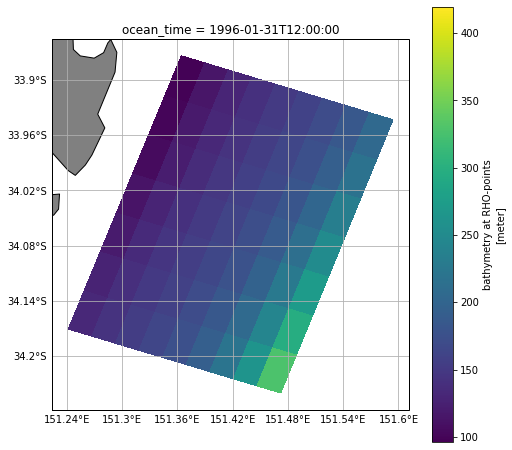

In [7]:
#quick plot to check
fig = plt.figure(figsize=(8,8))
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
ax = plt.axes(projection=ccrs.PlateCarree())
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
ds.h.sel(ocean_time='1996-01-31T12').plot(ax=ax, transform=ccrs.PlateCarree(), 
                                        x='lon_rho', y='lat_rho')
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = gl.ylabels_right = False

In [43]:
#Calculate heat transport, and sanity check that xgcm is calculating areas and volumes right.
Cp = 4181.3
Rho_0 = 1025
Volume = ds.h/(ds.pm*ds.pn)
V0 = Volume.sum(['eta_rho', 'xi_rho'])
V0.mean().values
V_A = (ds.dA*ds.h).sum(['eta_rho', 'xi_rho'])
print(V_A[0].values,V0[0].values)

180394266745.01105 180394266745.01105


In [14]:
n = (Cp*Rho_0*(grid.integrate(ds.T_vz, 'X').sel(eta_rho=-1)*-1)).load()
s = (Cp*Rho_0*grid.integrate(ds.T_vz, 'X').sel(eta_rho=0)).load()
w = (Cp*Rho_0*grid.integrate(ds.T_uz, 'Y').sel(xi_rho=0)).load()
e = (Cp*Rho_0*grid.integrate(ds.T_uz, 'Y').sel(xi_rho=-1)*-1).load()
tot_heat_adv = (n+s+e+w) #Total heat advection, which should be in Watts 

Text(0.5, 1.0, 'heat transport into box [W]')

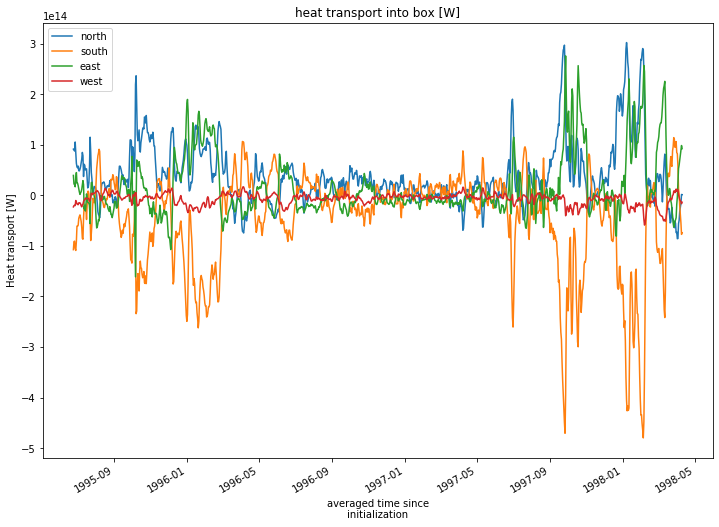

In [16]:
fig = plt.figure(figsize=(12,8))
n.plot(label='north')
s.plot(label='south')
e.plot(label='east')
w.plot(label='west')
plt.legend()
plt.ylabel('Heat transport [W]')
plt.title('heat transport into box [W]')
#plt.savefig('heat_transport.png', dpi=300,bbox_inches='tight')

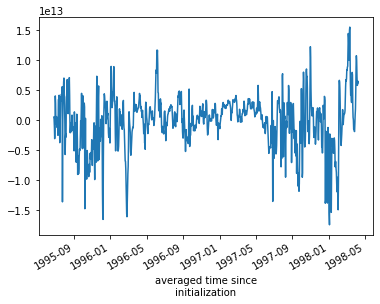

In [18]:
tot_heat_adv.plot()

In [19]:
ds.shflux

<xarray.DataArray 'shflux' (ocean_time: 1020, eta_rho: 8, xi_rho: 10)>
dask.array<open_dataset-ea2342cbb4df7d116bac7bc967f02e35shflux, shape=(1020, 8, 10), dtype=float32, chunksize=(1, 8, 10), chunktype=numpy.ndarray>
Coordinates:
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(8, 10), meta=np.ndarray>
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(8, 10), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 1995-06-25T12:00:00 ... 1998-04-09T12:00:00
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:       time-averaged surface net heat flux
    units:           watt meter-2
    negative_value:  upward flux, cooling
    positive_value:  downward flux, heating
    time:            ocean_time
    field:           surface heat flux, scalar, series

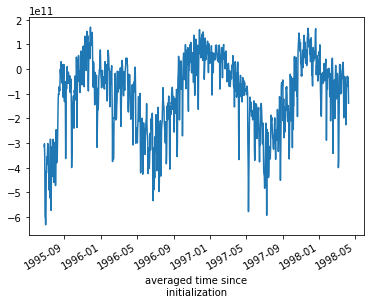

In [22]:
# Surface heat flux 
tot_Q = (grid.integrate(ds.shflux, ['X','Y'])).load() # produces same result as line below - so xgcm works for this
#tot_Q = ds.shflux.sum(dim=['eta_rho','xi_rho'])*2500*5000# W/m^2*m^2 = W can do this more exactly later
tot_Q.plot()

Text(0.5, 1.0, 'total heat transport into box')

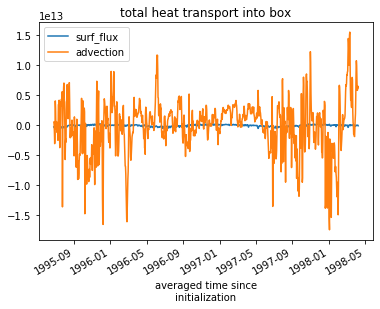

In [23]:
tot_Q.plot(label= 'surf_flux')
tot_heat_adv.plot(label='advection')
plt.legend()
plt.title('total heat transport into box')

Text(0.5, 1.0, 'total energy input from Qnet & advection [J]')

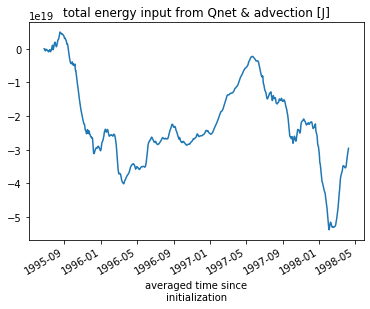

In [24]:
calc_tendency = (tot_heat_adv + tot_Q) # Watts + Watts
ADV_Q = (calc_tendency*86400).cumsum() # Watts is J/s, so we multiply by no. of seconds in a day to get a daily value in J.
ADV_Q.plot()
plt.title('total energy input from Qnet & advection [J]')

In [101]:
# Total heat in joules put into system by advection and atmospheric cooling
ADV_Q.sum().values

array(-2.27423565e+22)

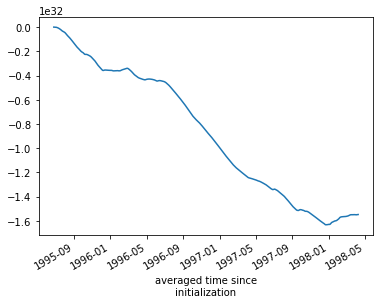

In [29]:
# Think that my mess up is in the below.
temperature_tendency = ((grid.integrate((ds.temp-ds.temp[0,:,:,:]), ['X','Y','Z'])*Rho_0*Cp*V0.mean())) # K*kg/m^3*J/kgK*m^3 = J
temperature_tendency.cumsum().plot()

In [30]:
temperature_tendency.sum().values

array(-1.54891465e+32)